#### This short example implements Shor's 9 qubit error correcting code along with error decoding and correction circuit in Qiskit. The fidelity of ideal input state is calculated with the state obtained after encoding and decoding suject to different discrete errors.

##### (The code is a bit longer than 20 lines, but that is due to non-Qiskit code and some analysis.)

##### Imports

In [1]:
import numpy as np

from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.quantum_info import partial_trace, state_fidelity

provider = IBMQ.load_account()
simulator = Aer.get_backend('statevector_simulator')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### Funtion to implement the full circuit. `init_callback` is used to specify callback function to initialize the input state. `error_callback` is used to inject user-defined errors on qubits specified by `error_qubits`.

In [2]:
def shor_code_ckt(init_callback = None, error_callback = None, error_qubits = [0]):
    num_qubits = 9
    shor_code = QuantumCircuit(num_qubits)
    if init_callback is not None:
        shor_code = init_callback(shor_code)
    shor_code.barrier()
    shor_code.cx(0,range(3,num_qubits,3))
    shor_code.h(range(0,num_qubits,3))
    shor_code.cx(range(0,num_qubits,3), range(1,num_qubits,3))
    shor_code.cx(range(0,num_qubits,3), range(2,num_qubits,3))
    shor_code.barrier()
    if error_callback is not None:
        for error_qubit in error_qubits:
            shor_code = error_callback(shor_code, error_qubit)
    shor_code.barrier()
    shor_code.cx(range(0,num_qubits,3), range(1,num_qubits,3))
    shor_code.cx(range(0,num_qubits,3), range(2,num_qubits,3))
    shor_code.ccx(range(2,num_qubits,3), range(1,num_qubits,3), range(0,num_qubits,3))
    shor_code.h(range(0,num_qubits,3))
    shor_code.cx(0,range(3,num_qubits,3))
    shor_code.ccx(6,3,0)
    
    return shor_code

##### Implementations of callbacks to initialize to arbitrary state and inject different types of errors.

In [3]:
def init_callback(ckt):
    ckt.rx(np.pi/4, 0)
    return ckt

def x_error_callback(ckt, qubit):
    ckt.x(qubit)
    return ckt

def y_error_callback(ckt, qubit):
    ckt.y(qubit)
    return ckt

##### First, calculate the ideal single qubit state which we encode later. This will be used to compare with state which is obtained after decoding of error correcting code.

In [4]:
ideal_state_ckt = QuantumCircuit(1)
ideal_state_ckt = init_callback(ideal_state_ckt)
result = execute(ideal_state_ckt, simulator).result()
ideal_state_q0 = result.get_statevector(ideal_state_ckt)
print(ideal_state_q0)

Statevector([0.92387953+0.j        , 0.        -0.38268343j],
            dims=(2,))


##### `ckt1` encodes this initial state in the QEC code with no errors injected. The output fidelity after decoding with ideal state is 1, as expected. This means state after decoding is same as initial state.

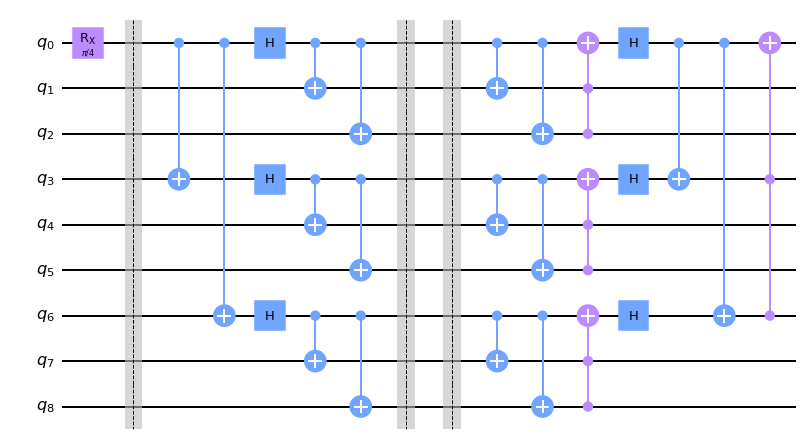

In [5]:
ckt1 = shor_code_ckt(init_callback)
ckt1.draw()

In [6]:
result = execute(ckt1, simulator).result()
statevector = result.get_statevector(ckt1)

state_q0_ckt1 = partial_trace(statevector, [1,2,3,4,5,6,7,8])
print("Fidelity = ", state_fidelity(ideal_state_q0, state_q0_ckt1))

Fidelity =  0.9999999999999998


##### `ckt2` encodes this initial state in the QEC code with Y error injected on qubit 6. The output fidelity after decoding with ideal state is 1, as expected because the QEC can correct one qubit errors. This means state after decoding is same as initial state.

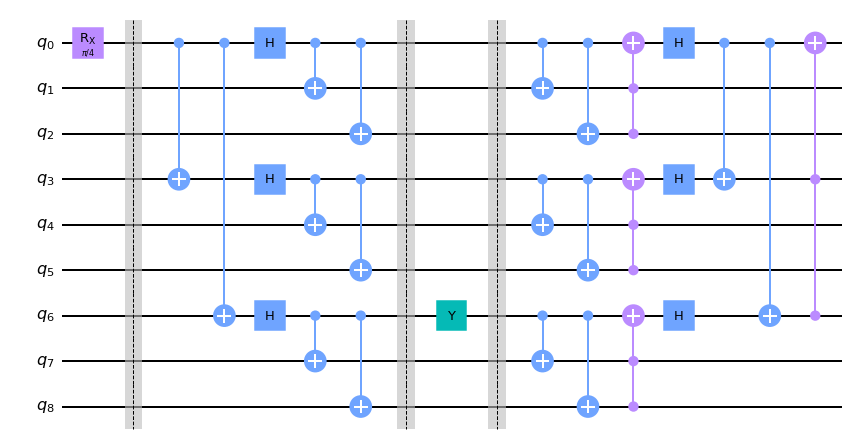

In [7]:
ckt2 = shor_code_ckt(init_callback, y_error_callback, [6])
ckt2.draw()

In [8]:
result = execute(ckt2, simulator).result()
statevector = result.get_statevector(ckt2)

state_q0_ckt2 = partial_trace(statevector, [1,2,3,4,5,6,7,8])
print("Fidelity = ", state_fidelity(ideal_state_q0, state_q0_ckt2))

Fidelity =  0.9999999999999998


##### `ckt3` encodes this initial state in the QEC code with X error injected on qubit 0. The output fidelity after decoding with ideal state is 1, as expected because the QEC can correct one qubit errors. This means state after decoding is same as initial state.

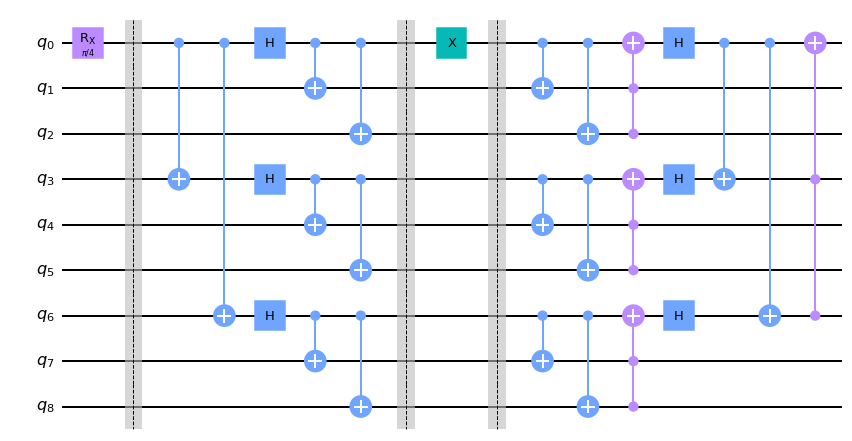

In [9]:
ckt3 = shor_code_ckt(init_callback, x_error_callback, [0])
ckt3.draw()

In [10]:
result = execute(ckt3, simulator).result()
statevector = result.get_statevector(ckt3)

state_q0_ckt3 = partial_trace(statevector, [1,2,3,4,5,6,7,8])
print("Fidelity = ", state_fidelity(ideal_state_q0, state_q0_ckt3))

Fidelity =  0.9999999999999998


##### `ckt4` and `ckt5` encode this initial state in the QEC code with errors injected on more than 1 qubits. The output fidelity after decoding with ideal state much lower than 1, as expected because the QEC can not correct more than one qubit errors. This means state after decoding is not the same as initial state.

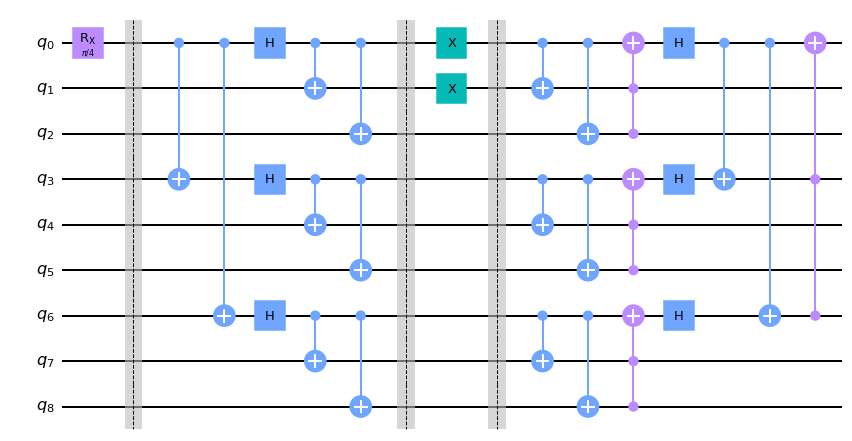

In [11]:
ckt4 = shor_code_ckt(init_callback, x_error_callback, [0,1])
ckt4.draw()

In [12]:
result = execute(ckt4, simulator).result()
statevector = result.get_statevector(ckt4)

state_q0_ckt4 = partial_trace(statevector, [1,2,3,4,5,6,7,8])
print("Fidelity = ", state_fidelity(ideal_state_q0, state_q0_ckt4))

Fidelity =  0.5


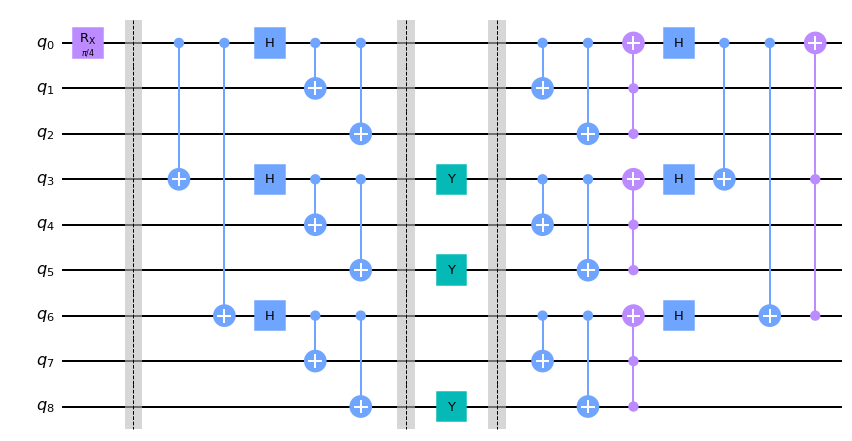

In [13]:
ckt5 = shor_code_ckt(init_callback, y_error_callback, [3,5,8])
ckt5.draw()

In [14]:
result = execute(ckt5, simulator).result()
statevector = result.get_statevector(ckt5)

state_q0_ckt5 = partial_trace(statevector, [1,2,3,4,5,6,7,8])
print("Fidelity = ", state_fidelity(ideal_state_q0, state_q0_ckt5))

Fidelity =  0.4999999999999999


##### Future ideas could be to inject continuous errors by noise model and to simulate the threshold of the code.
##### _End of notebook_